In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# MNIST

http://yann.lecun.com/exdb/mnist/

Base de datos de digitos escritos a mano.

* 60,000 imágenes de entrenamiento.
* 10,000 imágenes de test.

Cada imagen es de 28x28, en escala de grises.

In [3]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(f'Train -> x: {x_train.shape}')
print(f'         y: {y_train.shape}')
print(f'Test -> x: {x_test.shape}')
print(f'        y: {y_test.shape}')

Using TensorFlow backend.


Train -> x: (60000, 28, 28)
         y: (60000,)
Test -> x: (10000, 28, 28)
        y: (10000,)


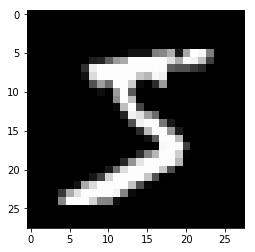

In [4]:
# Veamos una muestra
plt.imshow(x_train[0], 'gray');

## Ajustamos las dimensiones de las imágenes

Para usar las imágenes en una multiplicación de matrices, esta necesita tener sólo 2 dimensiones.

In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
x_train = x_train.reshape([60000, 28*28])
x_test = x_test.reshape([10000, 28*28])
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

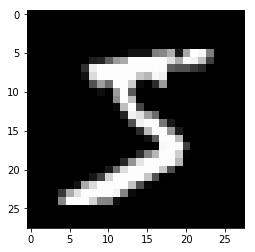

In [7]:
# Podemos usar el reshape de nuevo, para mostrar la imagen
plt.imshow(x_train[0].reshape([28,28]), 'gray');

## Definimos un modelo

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

lr = 0.01
bs = 256
nb = math.ceil(len(x_train)/bs) # Nro de batches

model = Sequential([
    Dense(128, activation='relu', input_shape=(784,)),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(SGD(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# La pérdida 'sparse_categorical_crossentropy' realiza automaticamente la conversión
# del target a one-hot encoding.

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


## Usemos el método de Learning rate finder

In [9]:
from custom_callbacks import LrFinder, reset_weights

lr_finder = LrFinder(nb)

model.fit(x_train, y_train, batch_size=bs, callbacks=[lr_finder]);

Epoch 1/1
60000/60000 [==============================] - 1s 24us/step - loss: 11.9131 - acc: 0.2498


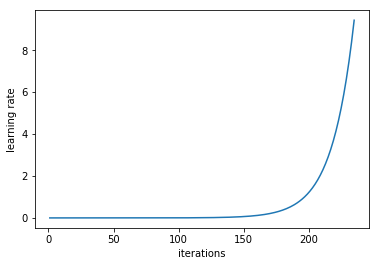

In [10]:
lr_finder.plot_lr()

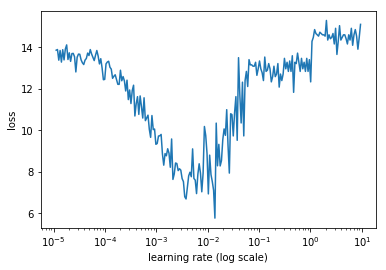

In [11]:
lr_finder.plot()

In [12]:
lr = 2e-3

## Entrenamiento

In [13]:
# Reseteamos los pesos y compilamos el modelo con el nuevo lr
reset_weights(model)
model.compile(SGD(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
log = model.fit(x_train, y_train, batch_size=bs, epochs=6, validation_data=[x_test, y_test])

Train on 60000 samples, validate on 10000 samples
Epoch 1/6
60000/60000 [==============================] - 1s 22us/step - loss: 9.3264 - acc: 0.4114 - val_loss: 8.6132 - val_acc: 0.4606
Epoch 2/6
60000/60000 [==============================] - 1s 20us/step - loss: 7.6966 - acc: 0.5131 - val_loss: 6.3832 - val_acc: 0.5920
Epoch 3/6
60000/60000 [==============================] - 1s 20us/step - loss: 5.9309 - acc: 0.6227 - val_loss: 5.8364 - val_acc: 0.6285
Epoch 4/6
60000/60000 [==============================] - 1s 22us/step - loss: 5.6998 - acc: 0.6382 - val_loss: 5.7705 - val_acc: 0.6337
Epoch 5/6
60000/60000 [==============================] - 1s 21us/step - loss: 5.5837 - acc: 0.6469 - val_loss: 5.6433 - val_acc: 0.6415
Epoch 6/6
60000/60000 [==============================] - 1s 20us/step - loss: 5.5127 - acc: 0.6512 - val_loss: 5.6598 - val_acc: 0.6415


In [15]:
def show_results(model, log, cycling=False):
    loss, acc = model.evaluate(x_test, y_test, batch_size=512, verbose=False)
    print(f'Loss     = {loss:.4f}')
    print(f'Accuracy = {acc:.4f}')
    
    val_loss = log.history['val_loss']
    val_acc = log.history['val_acc']
    if cycling:
        val_loss += [loss]
        val_acc += [acc]
        
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    ax1, ax2 = axes
    ax1.plot(log.history['loss'], label='train')
    ax1.plot(val_loss, label='test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(log.history['acc'], label='train')
    ax2.plot(val_acc, label='test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
    for ax in axes: ax.legend()

Loss     = 5.6598
Accuracy = 0.6415


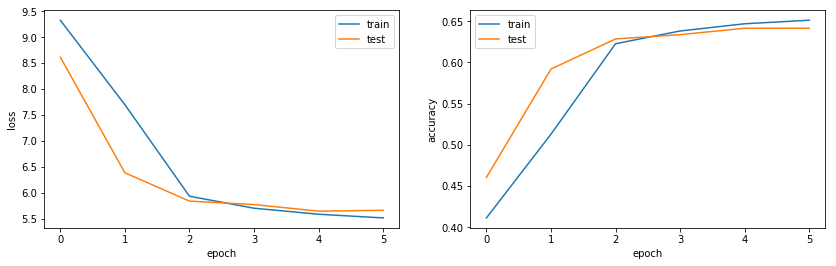

In [16]:
show_results(model, log)

## Cycling learning rates

In [17]:
from custom_callbacks import CycleLearner

cycle_learner = CycleLearner(lr, nb, n_cycle=3)

In [18]:
reset_weights(model)
log = model.fit(x_train, y_train, batch_size=bs, epochs=100,
                validation_data=[x_test, y_test], callbacks=[cycle_learner])
# Nota: la cantidad de epocas la va a controlar el callback.

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 1s 24us/step - loss: 7.5450 - acc: 0.5150 - val_loss: 6.2063 - val_acc: 0.6037
Epoch 2/100
60000/60000 [==============================] - 1s 22us/step - loss: 4.8989 - acc: 0.6810 - val_loss: 4.5308 - val_acc: 0.7059
Epoch 3/100
59648/60000 [============================>.] - ETA: 0s - loss: 4.3968 - acc: 0.7149

Loss     = 4.3370
Accuracy = 0.7189


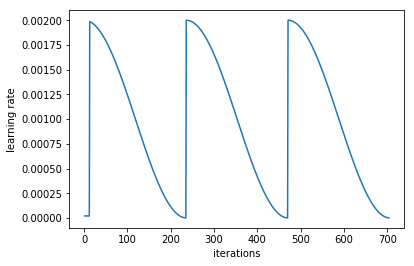

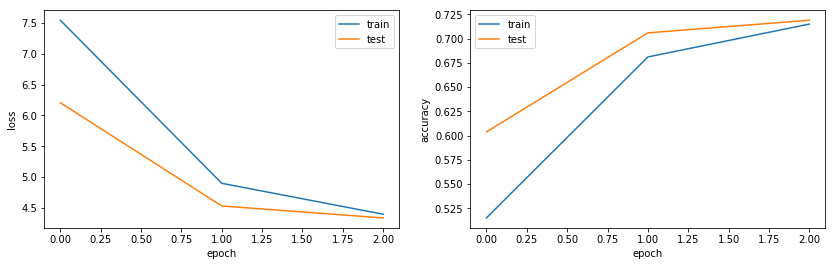

In [19]:
cycle_learner.plot_lr()
show_results(model, log, cycling=True)

In [20]:
# El parametro "cycle_mult" permite que cada ciclo sea mayor al anterior,
# en este caso el doble del anterior

# Esta vez no reseteamos los parametros
# pero vamos a disminuir el learning rate

cycle_learner = CycleLearner(lr/2, nb, n_cycle=3, cycle_mult=2)
log = model.fit(x_train, y_train, batch_size=bs, epochs=100,
                validation_data=[x_test, y_test], callbacks=[cycle_learner])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 1s 24us/step - loss: 4.2266 - acc: 0.7278 - val_loss: 4.2412 - val_acc: 0.7256
Epoch 2/100
60000/60000 [==============================] - 1s 24us/step - loss: 4.1653 - acc: 0.7311 - val_loss: 4.1937 - val_acc: 0.7293
Epoch 3/100
60000/60000 [==============================] - 1s 25us/step - loss: 4.0592 - acc: 0.7390 - val_loss: 4.1390 - val_acc: 0.7319
Epoch 4/100
60000/60000 [==============================] - 1s 24us/step - loss: 3.4052 - acc: 0.7738 - val_loss: 2.9819 - val_acc: 0.8002
Epoch 5/100
60000/60000 [==============================] - 1s 24us/step - loss: 2.7684 - acc: 0.8157 - val_loss: 2.8473 - val_acc: 0.8103
Epoch 6/100
60000/60000 [==============================] - 1s 23us/step - loss: 2.6348 - acc: 0.8256 - val_loss: 2.7714 - val_acc: 0.8144
Epoch 7/100
58880/60000 [============================>.] - ETA: 0s - loss: 2.5750 - acc: 0.8304

Loss     = 2.7610
Accuracy = 0.8149


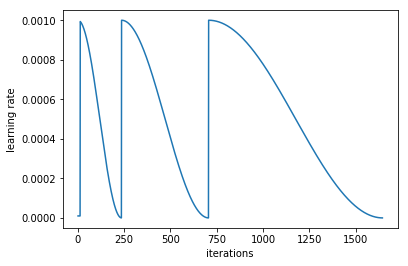

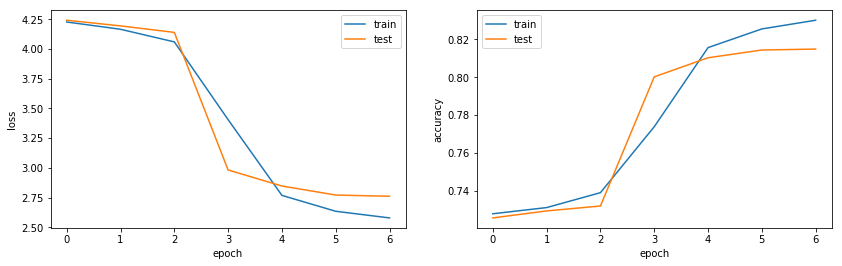

In [21]:
cycle_learner.plot_lr()
show_results(model, log, cycling=True)

## Snapshot ensembles

In [93]:
# Iniciamos el entrenamiento de forma normal
reset_weights(model)
cycle_learner = CycleLearner(lr, nb, n_cycle=3, cycle_mult=2)
log = model.fit(x_train, y_train, batch_size=bs, epochs=100,
                validation_data=[x_test, y_test], callbacks=[cycle_learner])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 1s 23us/step - loss: 6.7823 - acc: 0.5618 - val_loss: 4.5775 - val_acc: 0.6980
Epoch 2/100
60000/60000 [==============================] - 1s 23us/step - loss: 3.4558 - acc: 0.7710 - val_loss: 2.8237 - val_acc: 0.8135
Epoch 3/100
60000/60000 [==============================] - 1s 22us/step - loss: 2.7162 - acc: 0.8210 - val_loss: 2.7101 - val_acc: 0.8219
Epoch 4/100
60000/60000 [==============================] - 1s 23us/step - loss: 2.7008 - acc: 0.8214 - val_loss: 2.6793 - val_acc: 0.8245
Epoch 5/100
60000/60000 [==============================] - 1s 23us/step - loss: 2.4696 - acc: 0.8380 - val_loss: 2.4972 - val_acc: 0.8358
Epoch 6/100
60000/60000 [==============================] - 1s 23us/step - loss: 2.3434 - acc: 0.8470 - val_loss: 2.4356 - val_acc: 0.8416
Epoch 7/100
58368/60000 [============================>.] - ETA: 0s - loss: 2.2697 - acc: 0.8527

In [126]:
# Ahora activamos los snapshots
cycle_learner = CycleLearner(lr/2, nb, n_cycle=3, cycle_len=2, snapshots=True, snapshots_name='mnist_test')
log = model.fit(x_train, y_train, batch_size=bs, epochs=100,
                validation_data=[x_test, y_test], callbacks=[cycle_learner])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 33us/step - loss: 2.2758 - acc: 0.8518 - val_loss: 2.3976 - val_acc: 0.8429
Epoch 2/100
60000/60000 [==============================] - 1s 24us/step - loss: 2.2233 - acc: 0.8559 - val_loss: 2.3881 - val_acc: 0.8431
Epoch 3/100
60000/60000 [==============================] - 1s 24us/step - loss: 2.2352 - acc: 0.8544 - val_loss: 2.3866 - val_acc: 0.8441
Epoch 4/100
60000/60000 [==============================] - 1s 23us/step - loss: 2.1770 - acc: 0.8594 - val_loss: 2.3794 - val_acc: 0.8438
Epoch 5/100
60000/60000 [==============================] - 1s 24us/step - loss: 2.1879 - acc: 0.8577 - val_loss: 2.3557 - val_acc: 0.8462
Epoch 6/100
59648/60000 [============================>.] - ETA: 0s - loss: 2.1357 - acc: 0.8629

Loss     = 2.3468
Accuracy = 0.8464


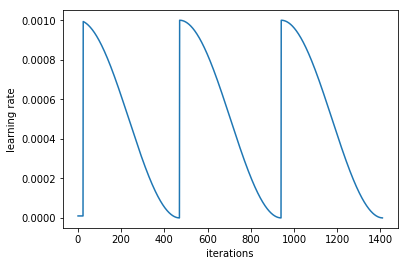

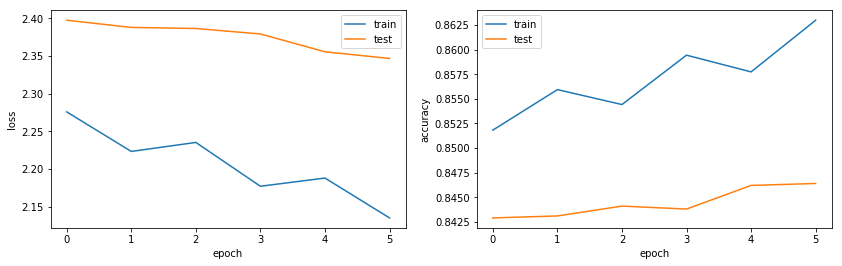

In [127]:
# Noten la diferencia de usar "cycle_len=2" en lugar de "cycle_mult=2" en CycleLearner
cycle_learner.plot_lr()
show_results(model, log, cycling=True)

In [128]:
# Veamos los archivos creados para los snapshots
from pathlib import Path

snapshots = Path('snapshots')
for file in snapshots.iterdir():
    print(file)

snapshots/mnist_test_1.hdf5
snapshots/mnist_test_2.hdf5
snapshots/mnist_test_3.hdf5


In [129]:
# Veamos ahora usando snapshots
snapshots_results = np.zeros([10000,10])

for file in snapshots.iterdir():
    model.load_weights(file)
    snapshots_results += model.predict(x_test) / 3
    
acc = (snapshots_results.argmax(axis=1) == y_test).mean()
print(f'Snapshot accuracy = {acc}')

Snapshot accuracy = 0.8446


# Ejercicio

Variar la arquitectura de la red y experimentar con las técnicas vistas en clase:
* Weight initialization.
* Regularización (Dropout, BatchNormalization).
* Distintos algoritmos de optimización.

In [ ]:
# COMPLETAR

# Otra base de datos para practicar:

``` python
from keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
```

In [1]:
# COMPLETAR